## Описание проекта 

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

---
---

### Описание услуг

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

---

### Цель проекта

__Цель данного проекта заключается в создании модели прогноза, способной предсказывать вероятность оттока клиентов. Это предсказание будет полезным для заказчика, так как он сможет предпринимать соответствующие меры для удержания клиентов и увеличения своей прибыли.__

---

### План

- Изучение данных:
    - Провести первичный осмотр данных
    - Проверить соответствие типов данных.
    - Проверить наличие пропусков.
    - Проверить регистр столбцов.

- Подготовка данных:
    - Соединить таблицы по полю customerID.
    - Определить значащие признаки и выделить целевой признак на основе имеющихся данных.
    - Изменить типы данных на необходимые
    - Создать новые признаки на основе существующих.
    - Разбить признаки на категориальные и численные.
    - Удалить столбцы, которые не несут   полезной информации или мешают работе.
    
       
- Исследовательский анализ данных
     - Построить графики для визуального исследования распределения данных.
     - Описать обнаруженные зависимости.
     - Исследовать распределение признаков, описать причины
     - Исследовать признаки на мультиколлинеарность. Построить график для наглядности.
     - Исследовать данные на дисбаланс классов. Построить график.
 
     
- Подготовка данных к обучению:
     - Разделить данные на обучающую и тестовую выборки.
     - Закодировать данные для обучения.
     
- Обучение модели:
     - Подготовить и обучить несколько моделей, перебрав гиперпараметры.
     - Определить наилучшую модель.
     
- Проверка модели:

    - Протестировать наилучшую модель на тестовой выборке.
    - Проанализировать матрицу ошибок.
    - Сделать анализ важности признаков.

- Вывод.
    - Написать общий вывод.
    
---

### Модули, функции, константы

In [1]:
# установим и обновим библиотеки
!pip install phik
!pip install -U scikit-learn

In [2]:
# загрузим модули 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
import phik

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import catboost as cb
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc

In [4]:
# изначально зададим константы для дальнейшей работы
RANDOM_STATE = 11092023

Отдельно выведу окно с функциями.

In [5]:
# добавим ф-цию для вывода основной инфы на экран
def main_df_info(df, df_name: str):
    print('-'*100)
    print(f'Набор данных: {df_name}\n')
    display(df.head(), df.tail())
    print('+++ Описание данных +++')
    display(df.describe())
    print('+++ Общая информация о данных +++')
    df.info()
    

In [6]:
# добавим ф-цию для проверки кол-во пропусков.
def check_missing_values(in_data):
    total = in_data.isnull().sum().sort_values(ascending=False)
    percent = (in_data.isnull().sum() / in_data.isnull().count() * 100).sort_values(ascending=False)
    miss_percent = pd.concat([percent], axis=1, keys=['percent'])
    miss_percent = miss_percent.query('percent != 0')
    print(miss_percent)
    

In [7]:
# добавим ф-цию проверки уникальных значений в столбцах
def display_unique_values(data, column_name):
    unique_values = data[column_name].dropna().unique().tolist()
    unique_values = sorted(unique_values, key=lambda x: str(x))
    print(f'{data[column_name].value_counts()}')
    

In [8]:
# добавим ф-цию визуализации числовых признаков
def plot_numeric_cols_2(data, numeric_cols, target_col):
    fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 15))
    colors = itertools.cycle(sns.color_palette('deep'))
    
    for i, col in enumerate(tqdm(numeric_cols, desc="Гистограмма и боксплот")):
        color = next(colors)
        ax_hist = sns.histplot(data=data, x=col, ax=axes[i][0], color=color, kde=True)
        ax_hist.set_xlabel(col)
        ax_hist.set_ylabel("Кол-во")
        
        ax_box = sns.boxplot(data=data, x=col, ax=axes[i][1], color=color, width=0.3)
        ax_box.set_xlabel(col)
        
        # настройка целевого признака
        ax_hist_target = ax_hist.twinx()
        sns.kdeplot(data=data[data[target_col] == 0][col], color='red', label=f'{target_col}=0', ax=ax_hist_target)
        sns.kdeplot(data=data[data[target_col] == 1][col], color='blue', label=f'{target_col}=1', ax=ax_hist_target)
        ax_hist_target.set_yticks([])  # Убираем метки оси y
        ax_hist_target.legend(loc='upper right')
        
    plt.tight_layout()
    plt.show()

In [9]:
# ф-ция для наглядного вывода результатов обучения моделей
def model_result(model):
    model_name = model.best_estimator_.named_steps['model'].__class__.__name__
    roc_auc_score = model.best_score_
    best_params = model.best_params_

    print(f"Model: {model_name}")
    print(f"ROC-AUC Score: {roc_auc_score:.4f}")
    print(f"Best parameters:")
    for param, value in best_params.items():
        print(f"\t{param}: {value}")

In [10]:
# ф-ция для построения матрицы ошибок
def plot_conf_matr(model_best, f_test, t_test):
    predictions = model_best.predict(f_test)
    num_records = t_test.shape[0]

    cf_matrix = confusion_matrix(predictions, t_test)

    plt.figure(figsize=(8, 6)) 
    ax = sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='RdYlBu', cbar=True)  
    ax.set_title(f'Матрица ошибок\nКоличество записей: {num_records}\n', fontsize=16) 
    ax.set_xlabel('\nПредсказанные значения', fontsize=14)  
    ax.set_ylabel('Фактические значения\n', fontsize=14)  
    ax.xaxis.set_ticklabels(['False', 'True'], fontsize=15)  
    ax.yaxis.set_ticklabels(['False', 'True'], fontsize=15) 
    
    plt.show()

In [11]:
def plot_categorical_distribution(data, target_column, categorical_columns, graphs_per_row=5):
    n_rows = len(categorical_columns) // graphs_per_row + len(categorical_columns) % graphs_per_row
    n_cols = graphs_per_row

    # генерируем фигуру, оси
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 6*n_rows))
    plt.subplots_adjust(hspace=0.5)  # Установка вертикального расстояния между графиками

    for i, col in enumerate(categorical_columns):
        row = i // n_cols
        col_idx = i % n_cols
        # группировка
        grouped_data = data.groupby(col)[target_column].value_counts().unstack(fill_value=0)

        axs[row, col_idx].set_title(f'Распределение {col}')
        grouped_data.plot(kind='bar', stacked=True, ax=axs[row, col_idx])
        axs[row, col_idx].set_xlabel(col)
        axs[row, col_idx].set_ylabel('Кол-во')

        # настройки легенды
        axs[row, col_idx].legend(title=f'{target_column}: %', loc='lower left', prop={'size': 8})
        axs[row, col_idx].grid(axis='y', linestyle='--', alpha=0.8)
        axs[row, col_idx].tick_params(axis='x', rotation=45)

        # настройка подписей на графиках
        for j, col_label in enumerate(grouped_data.columns):
            for i, value in enumerate(grouped_data[col_label]):
                total = grouped_data.iloc[i, :].sum()
                percent = (value / total) * 100
                axs[row, col_idx].annotate(f'{percent:.1f}%', xy=(i, grouped_data.iloc[i, :j].sum() + value / 2),
                                           ha='center', fontsize=11)
    # очистка
    if len(categorical_columns) % n_cols != 0:
        for i in range(len(categorical_columns) % n_cols, n_cols):
            fig.delaxes(axs[n_rows - 1, i])

    plt.tight_layout()
    plt.show()

In [12]:
def plot_correlation_matrix(data, num_list, matrix_size=(16, 8), threshold=0.75):
    corr = data.phik_matrix(interval_cols=num_list)

    # настройка маски для скрытия
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan

    plt.figure(figsize=matrix_size)
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")
    sns.heatmap(corr,
                annot=True,
                fmt=".2f",
                cmap='coolwarm',
                vmin=-1,
                vmax=1,
                mask=mask)

    plt.gca().set_facecolor('#f1f1f1')
    plt.title("Матрица корреляции")

    # отбор признаков с корреляцией > threshold
    high_corr_features = [(feature1, feature2, f'{corr.loc[feature1, feature2]:.2f}')
                          for feature1 in corr.columns for feature2 in corr.columns if
                          (feature1 != feature2) and (corr.loc[feature1, feature2] > threshold)]

    # настройка таблички признаков с высокой корреляцией.
    if high_corr_features:
        columns = ['Признак 1', 'Признак 2', 'Корреляция']
        table = plt.table(cellText=high_corr_features,
                          colLabels=columns,
                          loc='upper right',
                          cellLoc='center',
                          bbox=[0.59, 0.62, 0.4, 0.35])

        table.auto_set_font_size(False)
        table.set_fontsize(11.5)
        table.scale(1, 2)

    plt.show()

In [13]:
def plot_feature_importance(importances_df, title="Важность признаков", xlabel="Важность", ylabel="Признак"):
    colors = sns.color_palette('husl', n_colors=len(importances_df))
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(importances_df['Feature'], importances_df['Importance'], color=colors)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()

    # доп. настройки для подписей
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.3f}', ha='left', va='center', fontsize=16,
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white', alpha=0.7))

    # фон
    ax.patch.set_facecolor('lightgray')

    plt.grid(True, linestyle='--', alpha=0.5, color='white')
    plt.show()

---

## Изучение данных

Проведем загрузку данных и изучим их.

In [14]:
# выполним загрузку датасетов
separator = ','
try:
    original_data_phone =  pd.read_csv('C:/jupyter_local/data_files/phone_new.csv', sep=separator)
    original_data_inet =  pd.read_csv('C:/jupyter_local/data_files/internet_new.csv', sep=separator)
    original_data_personal =  pd.read_csv('C:/jupyter_local/data_files/personal_new.csv', sep=separator)
    original_data_contact =  pd.read_csv('C:/jupyter_local/data_files/contract_new.csv', sep=separator)
except:
    original_data_phone = pd.read_csv('/datasets/phone_new.csv', sep=separator)
    original_data_inet = pd.read_csv('/datasets/internet_new.csv', sep=separator)
    original_data_personal = pd.read_csv('/datasets/personal_new.csv', sep=separator)
    original_data_contact = pd.read_csv('/datasets/contract_new.csv', sep=separator)
    

Выведем основную информацио о каждом датасете. Для этого воспользуемся функцией main_df_info, которая объединит общую информацию о каждом из датасетов и выведет её на экран.

In [15]:
sheets = [original_data_contact,
          original_data_personal,
          original_data_inet,
          original_data_phone]
sheets_names = ['Информация о договоре', 
               'Информация о клиенте', 
               'Информация об интернет-услугах', 
               'Информация об телефонии']

for df, df_name in zip(sheets, sheets_names): 
    main_df_info(df, df_name)
    print('-' * 100)

----------------------------------------------------------------------------------------------------
Набор данных: Информация о договоре



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82


+++ Описание данных +++


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


+++ Общая информация о данных +++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Набор данных: Информация о клиенте



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No


+++ Описание данных +++


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


+++ Общая информация о данных +++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Набор данных: Информация об интернет-услугах



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


+++ Описание данных +++


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


+++ Общая информация о данных +++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Набор данных: Информация об телефонии



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes
6360,3186-AJIEK,No


+++ Описание данных +++


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


+++ Общая информация о данных +++
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
----------------------------------------------------------------------------------------------------


__Вывод:__ 

- Данные загружаются и отображаются корректно.
- Названия столбцов соответствуют регистру _CamelCase_, кроме столбцов `customerID` и `gender`, необходимо это исправить. `customerID` нам нужен только для объединения, поэтому оставим его как есть.
- При первичном осмотре явные пропуски отсутствуют,
- В столбце `TotalCharges` выявлен неверный тип данных, тип данных должен быть `float`
- Столбец `EndDate` содержит слово 'No' для клиентов, договор которых не истек на момент 01.02.2020, необходимо заменить это значение на крайнюю ааактуальную дату.
- `BeginDate` и `EndDate` по факту не несут необходимой нам дальше информации, полезнее для будущей работы нам было бы знать срок между этими датами, чтобы определить сколько клиент пользовался услугами. Для этого так же необходимо привести их к типы даты
- Целевой признак придется выделить самостоятельно на основании того, является человек клиентом или уже ушел, для этого будем использовать столбец `EndDate` и на его основе выделим необходимый нам целевой признак.
- Для дальнейшей работы нам необходимо соединить все датасеты по столбцу `customerID`
- Далее необходимо будет исследовать категориальные признаки на уникальность и распределение значений.

---

## Подготовка данных

На основании первичного изучения наборов данных и руководствуясь сделанными выводами приступим непосредственно к подготовке данных. 

Для начала соединим наборы данных.

In [16]:
total_data = original_data_personal.merge(original_data_contact, how = 'left', on = 'customerID')\
    .merge(original_data_inet, how = 'left', on = 'customerID').\
    merge(original_data_phone, how = 'left', on = 'customerID')

In [17]:
display(total_data.head())
display(total_data.tail())
total_data.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Fiber optic,No,No,No,No,No,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8,Fiber optic,No,No,No,No,No,No,Yes
7042,3186-AJIEK,Male,0,No,No,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Мы получили единый датасет в котором образовались пропуски из-за объединения. Эти пропуски необходимо будет обработать.

In [18]:
# изменим название столбца gender
total_data.rename(columns={'gender': 'Gender'}, inplace=True)

In [19]:
# изменим тип данных в столбце TotalCharges
total_data['TotalCharges'] = pd.to_numeric(total_data['TotalCharges'], errors ='coerce')

In [20]:
# изменим тип данных в столбце SeniorCitizen
total_data['SeniorCitizen'] = total_data['SeniorCitizen'].astype(str)

In [21]:
# создадим целевой признак CheckClient, 0 - клиент не ушел, 1 - клиент ушел
total_data['CheckClient'] = np.where(total_data.EndDate != 'No', 1, 0).astype(int)

In [22]:
# код тимлида для проверки
assert (total_data['CheckClient'] == (total_data.EndDate != 'No').astype(int)).all(), 'Целевая переменная создана неправильно'

In [23]:
# заменим No в столбце EndDate на крайнюю дату 01.02.2020
total_data['EndDate'] = total_data.EndDate.replace('No', '2020-02-01')

In [24]:
# изменим тип столбцов BeginDate и EndDate
total_data['BeginDate'] = pd.to_datetime(total_data.BeginDate, format='%Y-%m-%d')
total_data['EndDate'] = pd.to_datetime(total_data.EndDate, format='%Y-%m-%d')

In [25]:
# создадим новый столбец UsePeriodDays в днях 
total_data['UsePeriodDays'] = (total_data.EndDate - total_data.BeginDate).dt.days

In [26]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   Gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   object        
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   datetime64[ns]
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

In [27]:
# изучим кол-во пропусков в наборе данных
check_missing_values(total_data)

                    percent
StreamingMovies   21.666903
StreamingTV       21.666903
TechSupport       21.666903
DeviceProtection  21.666903
OnlineBackup      21.666903
OnlineSecurity    21.666903
InternetService   21.666903
MultipleLines      9.683374
TotalCharges       0.156183


Видим довольно значительное кол-во пропусков в нескольких столбцах, их необходимо обработать, но сначала посмотрим какие значения содержаться в них.

Для удобства выделим из датасета числовые и категориальные столбцы.

In [28]:
# чмсловые столбцы
num_list = ['MonthlyCharges',
            'TotalCharges',
            'UsePeriodDays']

In [29]:
# проверим категориальные столбцы на уникальные значения, в том числе чтобы лучше понимать какие замены сделать
ctg_list = [
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'InternetService',
    'OnlineSecurity',
    'StreamingMovies',
    'StreamingTV',
    'TechSupport',
    'DeviceProtection',
    'OnlineBackup',
    'MultipleLines',
]

In [30]:
# выведем на экран уникальные значения набора столбцов
for _ in ctg_list:
    display_unique_values(total_data, _)

Male      3555
Female    3488
Name: Gender, dtype: int64
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64
No     2810
Yes    2707
Name: StreamingTV, dtype: int64
No     3473
Yes    2044
Name: TechSupport, dtype: int64
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
No     3390
Yes    2971
Name: Mu

In [31]:
# дополнительно изучим пропуски в столбце TotalCharges
total_data[total_data.TotalCharges.isnull()]

,customerID,Gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,CheckClient,UsePeriodDays
488,4472-LVYGI,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
753,3115-CZMZD,Male,0,No,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
936,5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
1082,4367-NUYAO,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1340,1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
3331,7644-OMVMY,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3826,3213-VVOLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
4380,2520-SGTTA,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5218,2923-ARZLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,One year,Yes,Mailed check,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
6670,4075-WKNIU,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,...,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0


---
Мы видим большое (более 20%) кол-во пропусков в столбцах `InternetService` , `OnlineSecurity`, `StreamingMovies`, `StreamingTV`, `TechSupport`, `DeviceProtection`, `OnlineBackup`.

Учитывая, что данные столбца означают наличие или отсутствие определенного вида услуги, а удалить такое кол-во пропусков мы не имеем права, то заменим пропуски на отсутствие услуги у клиента.

Также в столбце `MultipleLines` около 10% данных пропущено, это так же скорее всего обозначает отсутствие данной опции у клиента, так что заменим пропуски на _'No'_.

В столбце `TotalCharges` есть небольшое (менее 1%) кол-во пропусков и как мы видим - это клиенты, которые только начали пользоваться услугами и еще не успели сделать оплату - заменим пропуски на 0

---

In [32]:
for column in ('InternetService',
               'OnlineSecurity',
               'OnlineBackup',
               'DeviceProtection',
               'TechSupport',
               'StreamingTV',
               'StreamingMovies',
               'MultipleLines'):
    total_data[column] = total_data[column].fillna('No')

In [33]:
total_data['TotalCharges'].fillna(0, inplace=True)

In [34]:
# повтороно проверим на пропуски
check_missing_values(total_data)

Empty DataFrame
Columns: [percent]
Index: []


In [35]:
# удалим столбцы BeginDate, EndDate, customerID
total_data = total_data.drop(['customerID', 'EndDate', 'BeginDate'], axis = 1)

In [36]:
# итоговая проверка после всех преобразований
display(total_data.info())
display(total_data.head())
display(total_data.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   TotalCharges      7043 non-null   float64
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


None

,Gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,CheckClient,UsePeriodDays
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No,0,31
1,Male,0,No,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,0,123
3,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No,0,153


,Gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,CheckClient,UsePeriodDays
7038,Male,0,Yes,Yes,One year,Yes,Mailed check,84.80,2035.20,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,730
7039,Female,0,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7430.40,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2191
7040,Female,0,Yes,Yes,Month-to-month,Yes,Electronic check,29.60,325.60,DSL,Yes,No,No,No,No,No,No,0,337
7041,Male,1,Yes,No,Month-to-month,Yes,Mailed check,74.40,520.80,Fiber optic,No,No,No,No,No,No,Yes,0,215
7042,Male,0,No,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No,0,2010


__Вывод:__ 
 
- Мы объединили таблицы по `customerID`. После объединения появились пропуски.
- В столбцах `InternetService` , `OnlineSecurity`, `StreamingMovies`, `StreamingTV`, `TechSupport`, `DeviceProtection`, `MultipleLines`, `TotalCharges` были обнаружены пропуски. Все они были обработаны согласно логике датасета.
- Название столбца `gender` было приведено к нужному регистру.
- Был изменен тип данных в столбце `TotalCharges` на числовой.
- В столбце `EndDate` значение _No_ было заменено на крайнюю актуальную дату _2020-02-01_.
- Были изменены типы данных в столбцах `BeginDate` и `EndDate`. Далее столбцы были преобразованы в `UsePeriod`, что означает период пользования услугами каждым из клиентов.
- На основании столбца `EndDate` был создан целевой признак `CheckClient` для дальнейшего обучения моделей.  1 - клиент, 0 - не клиент.
- Столбцы `customerID`, `EndDate`, `BeginDate` удалены после всех сделанных преобразований за ненадобностью. 

---

## Исследовательский анализ данных

После приведения всех данных в нормальный вид проведем исследовательский анализ данных.

Гистограмма и боксплот: 100%|████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.48it/s]


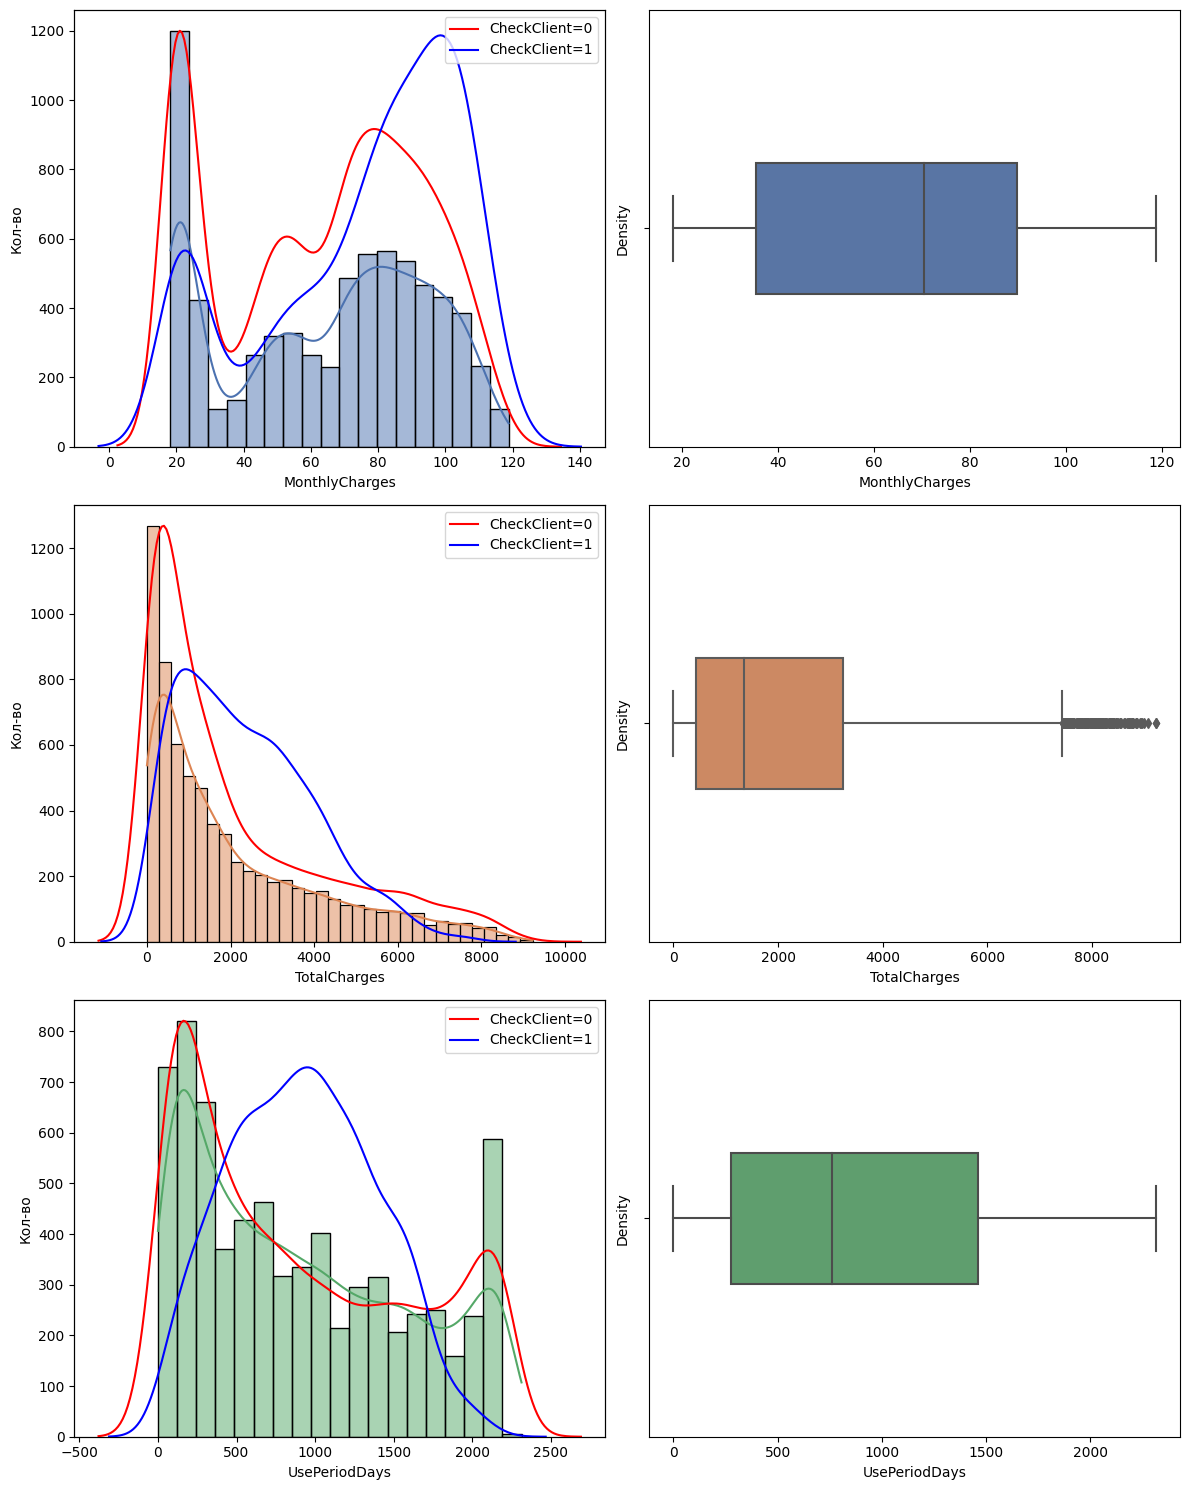

In [37]:
plot_numeric_cols_2(total_data, num_list, target_col='CheckClient')

- В столбце `MonthlyCharges` наблюдаются всплески в районе минимального значения(20) и значения 80. По распределению целевого признака мы так же видим, что чем больше у клиентов ежемесячные траты, тем чаще они уходят.
- Столбец `TotalCharges` показывает, что основная масса клиентов платит минимальную ставку и доля ушедших там заметно ниже, чем, к примеру, при общих тратах в 2000. Так же мы наблюдаем, что с ростом трат - растет и число ушедших клиентов примерно да отметки в 6000. Дальше можно обнаружить, что у клиентов с общими тратами более 6000 - процент ушедших резко снижается. Все это может означать, что клиенты делятся на две основных категории по признаку состоятельности.
- Столбец `UsePeriodDays` показывает, что доля ушедших клиентов начинает расти после 500 дня пользования услугами. Так же отображает два всплеска на графике, что так же подтверждает теорию двух основных групп, только уже по временному признаку.

Далее исследуем категориальные признаки.

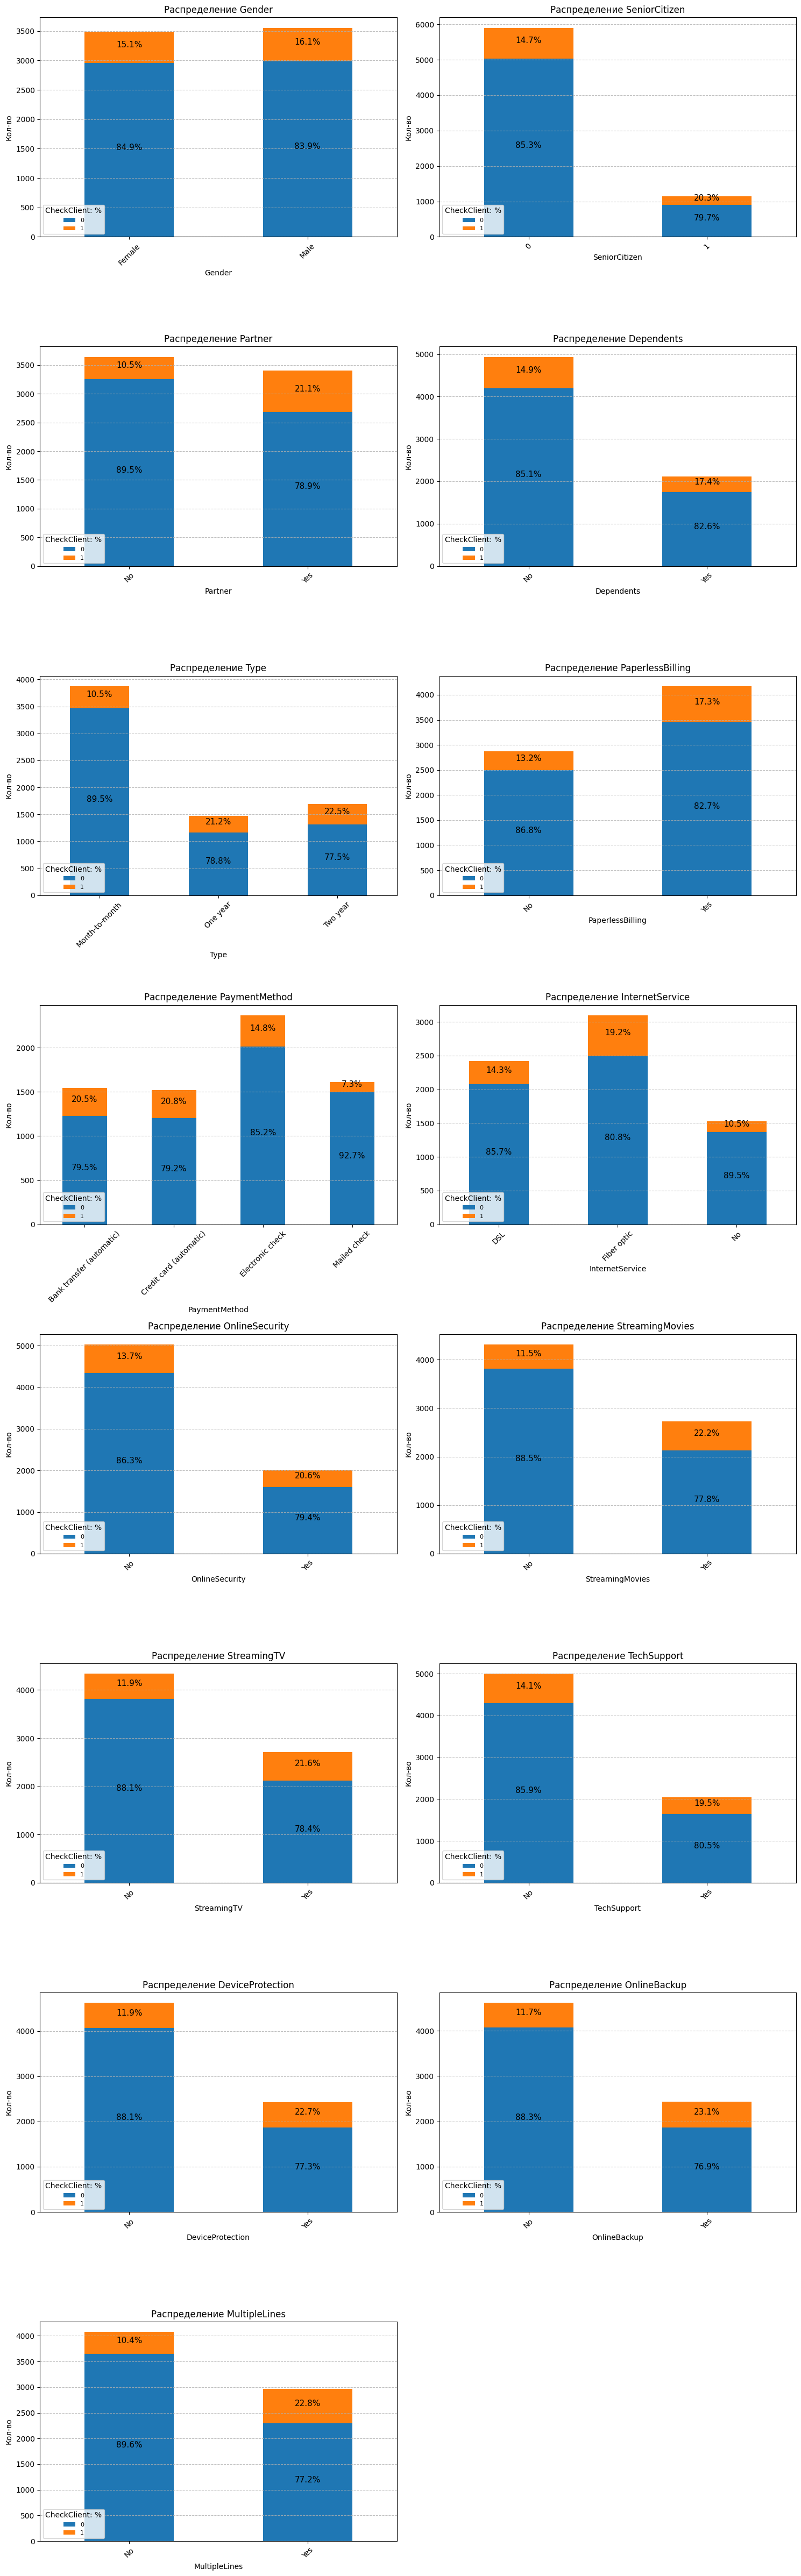

In [38]:
plot_categorical_distribution(total_data, 'CheckClient', ctg_list, graphs_per_row=2)

---
- Согласно графикам мы видим, что по признаку `Gender` данные распределены ровно, как по кол-ву записей, так и по целевому признаку. Единственное, что процент ушедших среди мужчин - больше на 1 процент.
- Статус `SeniorCitizen` большинство клиентов не имеют. Это логично, люди в возрасте реже пользуются такого рода услугами. Так же можно увидеть, что процент отказа от услуг выше у людей старшего возраста.
- Клиентов со статусом `Dependents` меньше, доля отказов среди них больше.
- Распределение по типу договора `Type` показывает, что большинство клиентов предпочитают платить ежемесячно, другие варианты используются значительно реже. Так же следует отметить, что доля отказов среди клиентов с ежемесячной оплатой в два раза меньше, чем у двух других вариантов.
- Большинство клиентов предпочитает выставление счетов по электронной почте `PaperlessBilling`, доля отказов среди них меньше на 4% 
- Согласно рапределению клиентов по способу оплаты `PaymentMethod` большинство предпочитают электронный чек. Далее идут автоматические способы оплаты : банковский перевод и кредитная карта, их распределение практически идентичное, как и процент отказа в 20%. С ними наравне и письменный чек, с минимальным процентом отказов. Письменный чеком скорее всего пользуются в большинстве пожилые люди, которые не хотят особо разбираться в тарифах и провайдерах, поэтому они реже их меняют.
- `InternetService` большинство клиентов имеют интернет в том или ином виде. Отказ среди клиентов без интернета значительно ниже.
- По признака, которые обозначают услуги `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` наблюдается следующее, в среднем люди, которые не пользуются услугами, в два раза реже отказываются от провайдера. Так же кол-во клиентов без доп. услуг в среднем выше, чем с доп. услугами.
---

Так как заказчик дополнительно обозначил проблемы мультиколлинеарности, то исследуем признаки на ее наличие. Выведем матрицу корреляции с дополнительным окном, которые отберет нам признаки с высокой (более 0.75) корреляцией. Эти признаки придется удалить, чтобы избежать проблемы мультиколлинеарности.

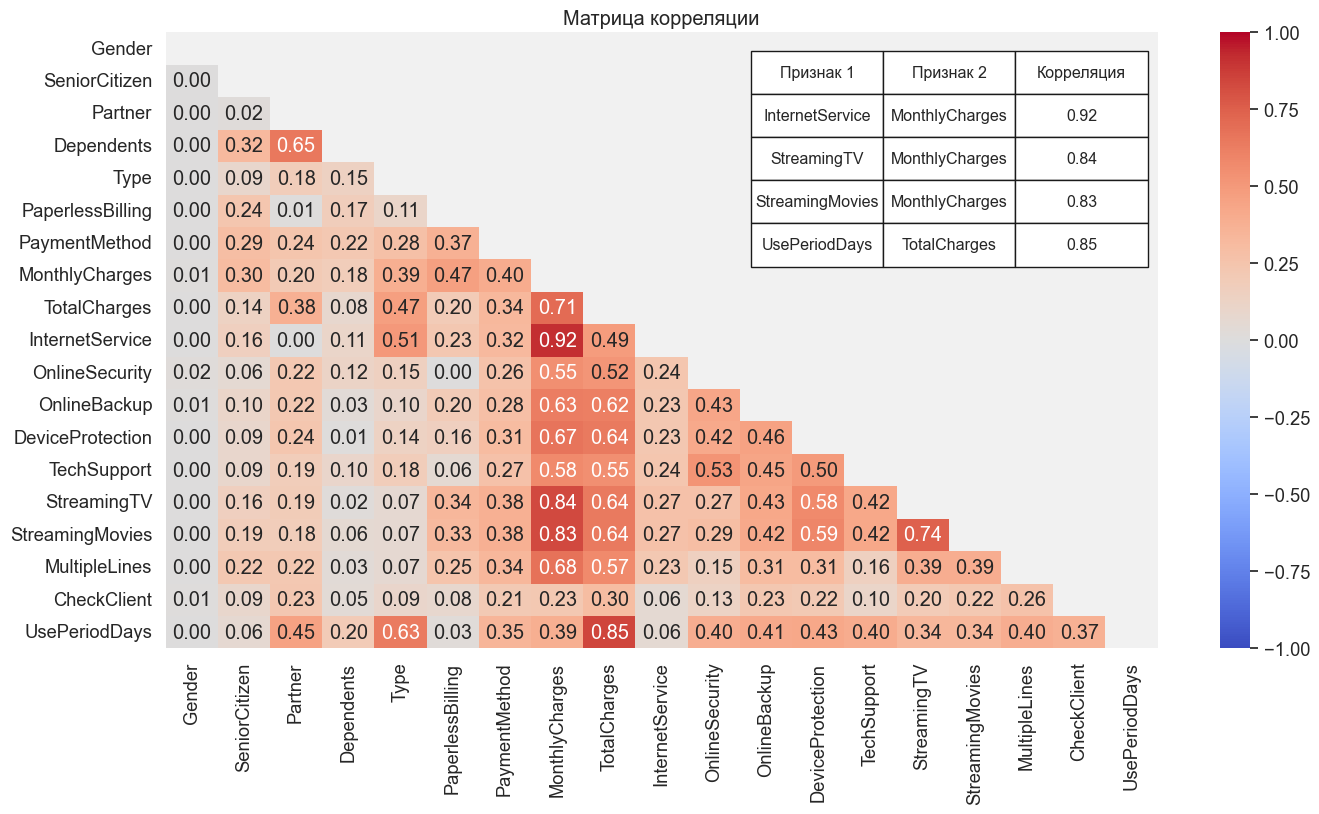

In [39]:
# Пример использования функции:
plot_correlation_matrix(total_data, num_list, matrix_size=(16, 8), threshold=0.75)

Учитывая, что нас беспокоит проблема мультиколлинеарности только между количественными признаками, мы видим, что между признаками `TotalCharges` и `UsePeriodDays` корреляция 0.85. Это логично, потому что чем дольше клиент пользуется услугами оператора, тем больше денег он платит, удалим признак `TotalCharges`. Так же мы видимо большие значения корреляции в признаках `InternetService`, `StreamingTV`, `StreamingMovies` - они могут повредить модели, их необходимо удалить.

In [40]:
total_data_2 = total_data.copy()

In [41]:
total_data_2 = total_data_2.drop(['TotalCharges'], axis = 1)
total_data_2 = total_data_2.drop(['InternetService', 'StreamingTV', 'StreamingMovies'], axis = 1)

Во время анализа данных в глаза очень бросалось то, что распредление классов целового признака `CheckClient` явно имеет дисбаланс в каждой из категорий данных. Отобразим данную проблему на круговой диаграмме.

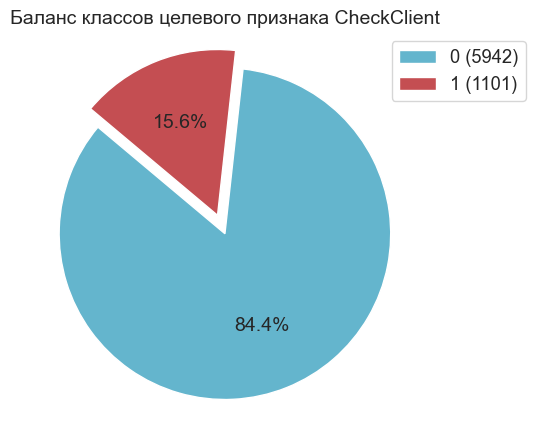

In [42]:
class_counts = total_data['CheckClient'].value_counts()

plt.figure(figsize=(5, 5))
colors = ['c', 'r']
explode = (0, 0.12) 
labels = [f'{label} ({count})' for label, count in zip(class_counts.index, class_counts)]
plt.pie(class_counts,
        labels=None,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=explode,
        textprops={'fontsize': 14})

plt.legend(labels, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title('Баланс классов целевого признака CheckClient', fontsize=14)
plt.axis('equal') 
plt.show()


Итоговая проверка

In [43]:
# итоговая проверка после всех преобразований
display(total_data_2.info())
display(total_data_2.head())
display(total_data_2.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Type              7043 non-null   object 
 5   PaperlessBilling  7043 non-null   object 
 6   PaymentMethod     7043 non-null   object 
 7   MonthlyCharges    7043 non-null   float64
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  CheckClient       7043 non-null   int32  
 14  UsePeriodDays     7043 non-null   int64  
dtypes: float64(1), int32(1), int64(1), object(12)
memory usage: 852.9+ KB


None

,Gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,MultipleLines,CheckClient,UsePeriodDays
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,No,Yes,No,No,No,0,31
1,Male,0,No,No,One year,No,Mailed check,56.95,Yes,No,Yes,No,No,0,1036
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,Yes,Yes,No,No,No,0,123
3,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,Yes,No,Yes,Yes,No,0,1371
4,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,No,No,No,No,No,0,153


,Gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,MultipleLines,CheckClient,UsePeriodDays
7038,Male,0,Yes,Yes,One year,Yes,Mailed check,84.80,Yes,No,Yes,Yes,Yes,0,730
7039,Female,0,Yes,Yes,One year,Yes,Credit card (automatic),103.20,No,Yes,Yes,No,Yes,0,2191
7040,Female,0,Yes,Yes,Month-to-month,Yes,Electronic check,29.60,Yes,No,No,No,No,0,337
7041,Male,1,Yes,No,Month-to-month,Yes,Mailed check,74.40,No,No,No,No,Yes,0,215
7042,Male,0,No,No,Two year,Yes,Bank transfer (automatic),105.65,Yes,No,Yes,Yes,No,0,2010


__Вывод:__ 

- Нами был проведен исследовательский анализ данных, мы обнаружили некоторые зависимости, которые ясно обозначили в работе
- Нами были построены наглядные графики, которые отражают распредление кол-ва клиентов, а так же долю ушедших и оставшихся клиентов
- Числовые признаки были проверены на мультиколлинеарность, чтобы избежать этой проблемы, был удален столбец `TotalCharges`
- Был обнаружен дисбаланс классов целевого признака `CheckClient` .


## Подготовка данных к обучению

Разобьем данные на тренировочную и тестовую выборку в пропорции 3:1.

In [44]:
# разбиваем данные
features = total_data_2.drop(['CheckClient'], axis=1)
target = total_data_2['CheckClient']

In [45]:
# проверка разбиения
print(f'features: {target.shape}')
print(f'target: {features.shape}')

features: (7043,)
target: (7043, 14)


In [46]:
# создадим выборки со стратификацией и перемешиванием
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target, shuffle=True)

In [47]:
# проверка разбиения выборок
print(f'features_train: {features_train.shape} | target_train: {target_train.shape}')
print(f'features_test: {features_test.shape}  | target_test: {target_test.shape}')

features_train: (5282, 14) | target_train: (5282,)
features_test: (1761, 14)  | target_test: (1761,)


Так как в будущем мы будем обучать и тестировать разные модели, то закодируем данные двумя разными способами под каждую из моделей. Использовать будем OHE и OrdinalEncoder. 

In [48]:
encod_features = features_train.select_dtypes(include='object').columns.to_list()
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

Закодируем данные двумя способами для разных моделей c помощью ф-ции _ColumnTransformer_

In [49]:
# трансформер с OneHotEncoder
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),  
        ('cat', OneHotEncoder(), encod_features)
    ]
)

In [50]:
# трансформер с OrdinalEncoder
preprocessor_oe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),  
        ('cat', OrdinalEncoder(), encod_features)
    ]
)

### Вывод

- Из подготовленных данных были созданы выборки в пропорциях 3 к 1
- Были созданы два экземпляра ф-ции трансформера для подготовки данных для разных моделей.
- Данные готовы для обучения моделей.

---

## Обучение моделей

Обучим и исследуем модели разной архитектуры :

 - `LogisticRegression`
 - `RandomForestClassifier`
 - `CatBoostClassifier`
 - `GradientBoostingClassifier`
 
Чтобы получить больше информации я не буду загонять все модели в один pipeline, а разобью по пунктам. Возможно код будет менее унифицировнным, но более наглядным.

### LogisticRegression

Изучим и обучим модель _LogisticRegression_.

In [51]:
# создадим пайплайн с предобработкой и моделью LogisticRegression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor_ohe),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

# добавим параметры подбора
lr_param_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'model__max_iter': [100, 200, 300],
    'model__class_weight': [None, 'balanced']
}

In [52]:
# создадим экземляр GridSearchCV для LogisticRegression
lr_grid_search = GridSearchCV(estimator=lr_pipeline,
                              param_grid=lr_param_grid,
                              scoring='roc_auc',
                              cv=5,
                              n_jobs=-1,
                              verbose=0)

# обучим модель с заданными параметрами
lr_grid_search.fit(features_train, target_train)
lr_grid_search.cv_results_ = {}

In [53]:
model_result(lr_grid_search)

Model: LogisticRegression
ROC-AUC Score: 0.7472
Best parameters:
	model__C: 1.0
	model__class_weight: balanced
	model__max_iter: 100
	model__penalty: l1
	model__solver: liblinear


---
Для модели  `LogisticRegression` :
 - ROC-AUC Score: __0.7472__
---

### RandomForestClassifier

Изучим и обучим модель _RandomForestClassifier_.

In [54]:
# создадим пайплайн с предобработкой и моделью RandomForestClassifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_oe),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))
])

# добавим параметры подбора
rf_param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

In [55]:
# создадим экземляр GridSearchCV для RandomForestClassifier
rf_grid_search = GridSearchCV(estimator=rf_pipeline,
                              param_grid=rf_param_grid,
                              scoring='roc_auc',
                              cv=5,
                              n_jobs=-1,
                              verbose=0)

# обучим модель с заданными параметрами
rf_grid_search.fit(features_train, target_train)
rf_grid_search.cv_results_ = {}

In [56]:
model_result(rf_grid_search)

Model: RandomForestClassifier
ROC-AUC Score: 0.8244
Best parameters:
	model__max_depth: 10
	model__min_samples_leaf: 2
	model__min_samples_split: 10
	model__n_estimators: 300


---
Для модели  `RandomForestClassifier` :
 - ROC-AUC Score: __0.8244__
---

### CatBoostClassifier

Изучим и обучим модель _CatBoostClassifier_.

In [57]:
# создадим пайплайн с предобработкой и моделью CatBoostClassifier
cb_pipeline = Pipeline([
    ('preprocessor', preprocessor_oe),
    ('model', cb.CatBoostClassifier(random_state=RANDOM_STATE))
])

In [58]:
# добавим параметры подбора
cb_param_grid = {
    'model__learning_rate': [0.01, 0.03, 0.001],
    'model__depth': range(1, 6)
}

In [59]:
# создадим экземляр GridSearchCV для CatBoostClassifier
cb_grid_search = GridSearchCV(estimator=cb_pipeline,
                              param_grid=cb_param_grid,
                              scoring='roc_auc',
                              cv=5,
                              n_jobs=-1,
                              verbose=False)

# обучим модель с заданными параметрами
cb_grid_search.fit(features_train, target_train)
cb_grid_search.cv_results_ = {}

0:	learn: 0.6672475	total: 143ms	remaining: 2m 22s
1:	learn: 0.6499542	total: 145ms	remaining: 1m 12s
2:	learn: 0.6285827	total: 147ms	remaining: 49s
3:	learn: 0.6069228	total: 150ms	remaining: 37.4s
4:	learn: 0.5885442	total: 153ms	remaining: 30.4s
5:	learn: 0.5710725	total: 155ms	remaining: 25.7s
6:	learn: 0.5531811	total: 158ms	remaining: 22.3s
7:	learn: 0.5406115	total: 160ms	remaining: 19.8s
8:	learn: 0.5260201	total: 162ms	remaining: 17.9s
9:	learn: 0.5122410	total: 165ms	remaining: 16.3s
10:	learn: 0.5042630	total: 166ms	remaining: 14.9s
11:	learn: 0.4961008	total: 168ms	remaining: 13.9s
12:	learn: 0.4873928	total: 171ms	remaining: 13s
13:	learn: 0.4771023	total: 173ms	remaining: 12.2s
14:	learn: 0.4678963	total: 176ms	remaining: 11.5s
15:	learn: 0.4611687	total: 178ms	remaining: 10.9s
16:	learn: 0.4525861	total: 186ms	remaining: 10.7s
17:	learn: 0.4457515	total: 188ms	remaining: 10.3s
18:	learn: 0.4387143	total: 190ms	remaining: 9.82s
19:	learn: 0.4315099	total: 193ms	remaining

In [60]:
model_result(cb_grid_search)

Model: CatBoostClassifier
ROC-AUC Score: 0.9052
Best parameters:
	model__depth: 5
	model__learning_rate: 0.03


---
Для модели  `CatBoostClassifier` :
 - ROC-AUC Score: __0.9052__
---

### GradientBoostingClassifier

Изучим и обучим модель _GradientBoostingClassifier_.

In [61]:
# создадим пайплайн с предобработкой и моделью GradientBoostingClassifier
pipeline_gbc = Pipeline([
    ('preprocessor', preprocessor_oe),
    ('model', GradientBoostingClassifier(random_state=RANDOM_STATE))  # модель градиентного бустинга
])

In [62]:
# добавим параметры подбора
gbc_param_grid = {
    'model__n_estimators': [50, 100, 200],  
    'model__learning_rate': [0.01, 0.1, 0.2],  
    'model__max_depth': [3, 4, 5]
}

In [63]:
# создадим экземляр GridSearchCV для GradientBoostingClassifier
gbc_grid_search = GridSearchCV(estimator=pipeline_gbc,
                               param_grid=gbc_param_grid,
                               scoring='roc_auc',
                               cv=5,
                               n_jobs=-1,
                               verbose=False)

# обучим модель с заданными параметрами
gbc_grid_search.fit(features_train, target_train)
gbc_grid_search.cv_results_ = {}

In [64]:
model_result(gbc_grid_search)

Model: GradientBoostingClassifier
ROC-AUC Score: 0.9063
Best parameters:
	model__learning_rate: 0.2
	model__max_depth: 4
	model__n_estimators: 200


---
Для модели  `GradientBoostingClassifier` :
 - ROC-AUC Score: __0.9063__
---

Соберем все результаты в таблицу для сравнительного анализа.

In [65]:
models = [
    ('LogisticRegression', lr_grid_search.best_score_),
    ('RandomForestClassifier', rf_grid_search.best_score_),
    ('CatBoostClassifier', cb_grid_search.best_score_),
    ('GradientBoostingClassifier', gbc_grid_search.best_score_)
]
roc_auc_df = pd.DataFrame(models, columns=['Model', 'ROC AUC'])
roc_auc_df['ROC AUC'] = roc_auc_df['ROC AUC'].round(4)

roc_auc_df

,Model,ROC AUC
0,LogisticRegression,0.7472
1,RandomForestClassifier,0.8244
2,CatBoostClassifier,0.9052
3,GradientBoostingClassifier,0.9063


### Вывод

- Были выбраны и обучены __4__ модели разных архитектур : `LogisticRegression`, `RandomForestClassifier`, `CatBoostClassifier`, `GradientBoostingClassifier` .
- Для обучения были использованы функция _Pipeline_, а так же метод подбора гиперпараметров _GridSearchCV_
- Модели были оценены с помощью метрики __ROC AUC__ и набором персональных гиперпараметров.
- Худшую оценку, по итогам обучения, получила модель `LogisticRegression` : __`0.7472`__
- Лучшая оценка была получена на модели `GradientBoostingClassifier` : __`0.9063`__


---

## Проверка модели

По итогам обучения и оценки с помощью метрики __ROC AUC__ лучшей моделью была признана `GradientBoostingClassifier`. Далее необходимо проверить модель на тестовых данных.

In [66]:
test_roc_auc = roc_auc_score(target_test, gbc_grid_search.best_estimator_.predict_proba(features_test)[:, 1])

In [67]:
round(test_roc_auc, 3)

0.94

---
На тестовых данных лучшей модели `GradientBoostingClassifier` получено __ROC AUC Score__ : __`0.94`__

---

#### Построение ROC-кривой

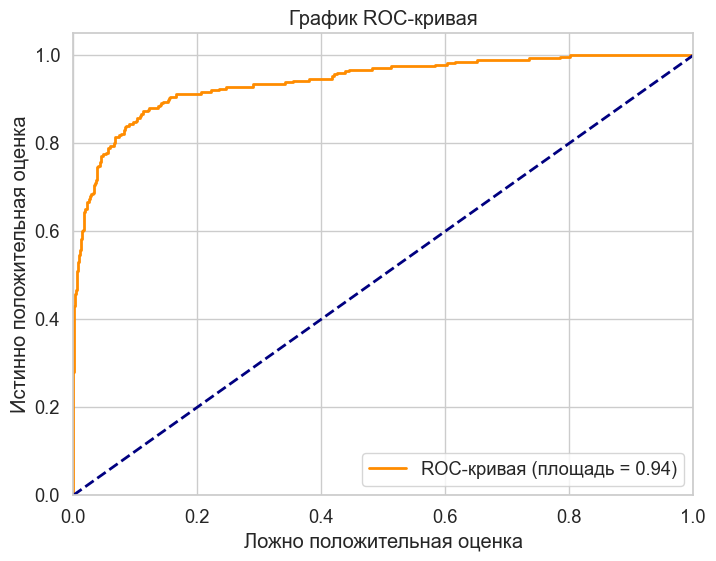

In [68]:
# расчет вероятности
probas = gbc_grid_search.best_estimator_.predict_proba(features_test)[:, 1]

# ROC-кривоя
fpr, tpr, thresholds = roc_curve(target_test, probas)
roc_auc = auc(fpr, tpr)

# визуализация
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-кривая (площадь = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложно положительная оценка')
plt.ylabel('Истинно положительная оценка')
plt.title('График ROC-кривая')
plt.legend(loc='lower right')
plt.show()

Проверенная на тестовых данных модель имеет `ROC AUC Score` : __0.94__. Это означает, что модель очень хорошо различает классы и имеет высокое качество предсказания, что и является нашей главной задачей.

Проведем дополнительный анализ с помощью второй метрики __accuracy__ для интерпретации. 

In [69]:
test_accuracy = accuracy_score(gbc_grid_search.best_estimator_.predict(features_test), target_test)

In [70]:
round(test_accuracy, 3)

0.93

---

На тестовых данных лучшей модели `GradientBoostingClassifier` получено __accuracy__ : __`0.93`__

---

### Построение матрицы ошибок.

Применим ф-цию _plot_conf_matr_ для построения матрицы ошибкок.

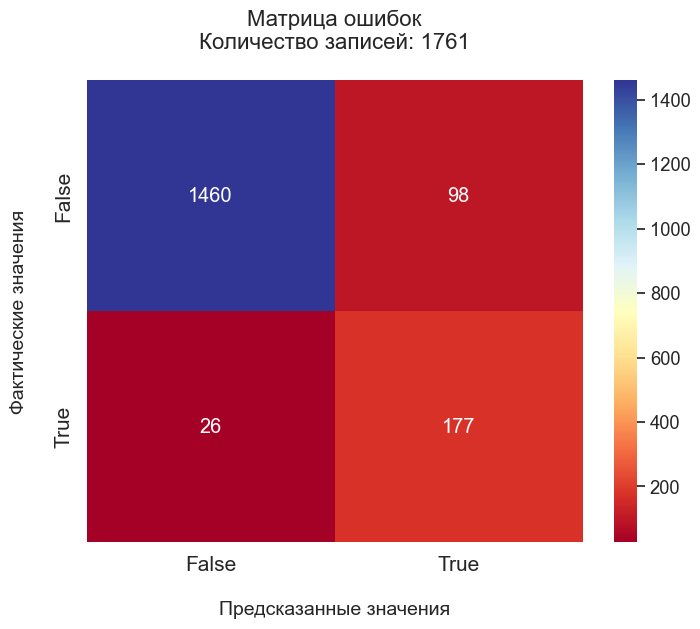

In [71]:
plot_conf_matr(gbc_grid_search,
               features_test,
               target_test)

Матрица ошибок представляет собой инструмент для анализа производительности модели.

- Верхний левый квадрант __(1460)__: Это кол-во истинно негативных _(True Negative)_ предсказаний модели. В данном контексте это означает, что модель правильно классифицировала __1460__ случаев, в которых клиент не уйдет.

- Верхний правый квадрант __(98)__: Это количество ложно позитивных _(False Positive)_ предсказаний модели. Модель неправильно классифицировала __98__ случаев как положительные, когда они на самом деле были отрицательными, т.е ошибка в предсказании клиентов, которые уйдут.

- Нижний левый квадрант __(26)__: Это количество ложно негативных _(False Negative)_ предсказаний модели. Модель неправильно классифицировала __26__ случаев как отрицательные, когда они на самом деле были положительными. В данном случае, что пользователи, которые не должны уйти - уйдут.

- Нижний правый квадрант __(177)__: Это количество истинных положительных _(True Positive)_ предсказаний модели. Модель правильно классифицировала __177__ случаев как положительные, и они были действительно положительными, т.е модель хорошо предсказывает пользователей, которые на самом деле не уйдут.

### Анализ важности признаков

Сначала запросим имена признаков, после трансформации с помощью метода _get_feature_names_out_ .

In [72]:
ohe_feature_names = gbc_grid_search.best_estimator_.named_steps['preprocessor'].\
                    get_feature_names_out(input_features=features_test.columns)

Также запросим важность признаков лучшей модели с помощью _feature_importances_. Далее объединим признаки и значения важности признаков в одну таблицу для дальнейшей визуализации.

In [73]:
importances = gbc_grid_search.best_estimator_.named_steps['model'].feature_importances_
importances_df = pd.DataFrame({'Feature': ohe_feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
# importances_df = importances_df[importances_df['Importance'] >= 0.01]
importances_df['Importance'] = importances_df['Importance'].round(4)

# проверка
importances_df

,Feature,Importance
1,num__UsePeriodDays,0.5788
0,num__MonthlyCharges,0.1643
6,cat__Type,0.0987
8,cat__PaymentMethod,0.0347
10,cat__OnlineBackup,0.0289
13,cat__MultipleLines,0.0223
4,cat__Partner,0.0203
11,cat__DeviceProtection,0.0179
3,cat__SeniorCitizen,0.0097
5,cat__Dependents,0.0059


Визуализируем таблицу важности признаков.

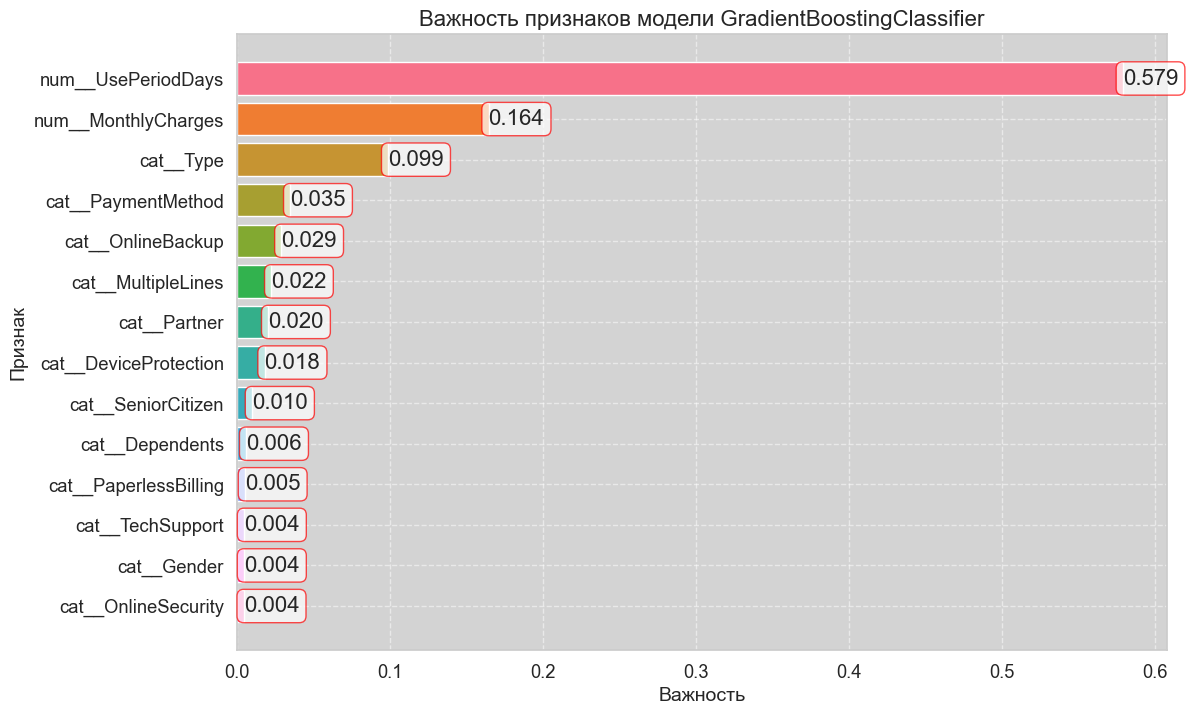

In [74]:
plot_feature_importance(importances_df,
                        title="Важность признаков модели GradientBoostingClassifier",
                        xlabel="Важность",
                        ylabel="Признак")

- `num__UsePeriodDays`  __0.579__ : Признак имеет наибольшую важность среди всех рассмотренных признаков. Из этого следует, что продолжительность пользования услугами больше других воздействует на результат исследования.
- `num__MonthlyCharges`  __0.164__: Второй по важности признак со значением 0.156. Размер ежемесячных платежей так же сильно влияет на исследование.
- `cat__Type` __0.099__ : Тип контракта также в значительной степени влияет на результат.
- `cat__OnlineBackup`, `cat__MultipleLines`, ` cat__DeviceProtection` : Отсутствие или наличие некоторых услуг сильнее других признаков влияет на результат предсказания.
- `cat__Partner` __0.020__ : Наличие супруги/супруга у клиента так же оказывает влияние на предсказания модели 
---
- В свою очередь такие признаки как, например, `cat__Gender` - меньше всего влияют на работу модели.
- Это так же относится и к услугам `cat__OnlineSecurity`, `cat__TechSupport`, которые так же практически не влияют на решения клиента уйти или остаться.


### Вывод

---

#### Подготовка данных к обучению.

- Из подготовленных данных были созданы выборки в пропорциях 3 к 1
- Были созданы два экземпляра ф-ции трансформера для подготовки данных для разных моделей.
- Данные готовы для обучения моделей.
---
#### Обучение моделей.

- Были выбраны и обучены __4__ модели разных архитектур : `LogisticRegression`, `RandomForestClassifier`, `CatBoostClassifier`, `GradientBoostingClassifier` .
- Для обучения были использованы функция _Pipeline_, а так же метод подбора гиперпараметров _GridSearchCV_
- Модели были оценены с помощью метрики __ROC AUC__ и набором персональных гиперпараметров.
- Худшую оценку, по итогам обучения, получила модель `LogisticRegression` : __`0.7472`__
- Лучшая оценка была получена на модели `GradientBoostingClassifier` : __`0.9063`__

| Модель                      | ROC AUC   |
|-----------------------------|-----------|
| LogisticRegression          | 0.7472    |
| RandomForestClassifier      | 0.8244    |
| CatBoostClassifier          | 0.9052    |
| GradientBoostingClassifier  | 0.9063    |

---
#### Построение ROC-кривой.

- Проверенная на тестовых данных модель имеет `ROC AUC Score` : __0.94__. Это означает, что модель очень хорошо различает классы и имеет высокое качество предсказаний, что и является нашей главной задачей. __Но так же хочу обратить внимание на наличие разницы между значенями метрики `ROC AUC` на тренировочных и тестовых данных, что может указывать на переобучение модели. При дальнейшем развитии модели, возможно, следует добавить такой параметр как _subsample_, который снизит риск переобучения модели при помощи регуляризации__


- На тестовых данных лучшей модели `GradientBoostingClassifier` получено __accuracy__ : __`0.93`__
---
#### Построение матрицы ошибок.

- Модель имеет хорошую способность правильно классифицировать клиентов, которые не уйдут (True Negative) и клиентов, которые действительно уйдут (True Positive), что вполне удовлетворяет нас.
---
#### Анализ важности признаков.

- `num__UsePeriodDays`  __0.579__ : Признак имеет наибольшую важность среди всех рассмотренных признаков. Из этого следует, что продолжительность пользования услугами больше других воздействует на результат исследования.
- `num__MonthlyCharges`  __0.164__: Второй по важности признак со значением 0.156. Размер ежемесячных платежей так же сильно влияет на исследование.
- `cat__Type` __0.099__ : Тип контракта также в значительной степени влияет на результат.
- `cat__OnlineBackup`, `cat__MultipleLines`, ` cat__DeviceProtection` : Отсутствие или наличие некоторых услуг сильнее других признаков влияет на результат предсказания.
- `cat__Partner` __0.020__ : Наличие супруги/супруга у клиента так же оказывает влияние на предсказания модели 
---
- В свою очередь такие признаки, как например пол клиента, `cat__Gender` - меньше всего влияют на работу модели.
- Это так же относится и к услугам `cat__OnlineSecurity`, `cat__TechSupport`, которые так же практически не влияют на решения клиента уйти или остаться.
---
---
---
<br>

# Общий вывод

__Цель данного проекта заключается в создании модели прогноза, способной предсказывать вероятность оттока клиентов. Это предсказание будет полезным для заказчика, так как он сможет предпринимать соответствующие меры для удержания клиентов и увеличения своей прибыли.__


---
### Изучение данных

- Данные загружаются и отображаются корректно.
- Названия столбцов соответствуют регистру _CamelCase_, кроме столбцов `customerID` и `gender`, необходимо это исправить. `customerID` нам нужен только для объединения, поэтому оставим его как есть.
- При первичном осмотре явные пропуски отсутствуют,
- В столбце `TotalCharges` выявлен неверный тип данных, тип данных должен быть `float`
- Столбец `EndDate` содержит слово 'No' для клиентов, договор которых не истек на момент 01.02.2020, необходимо заменить это значение на крайнюю ааактуальную дату.
- `BeginDate` и `EndDate` по факту не несут необходимой нам дальше информации, полезнее для будущей работы нам было бы знать срок между этими датами, чтобы определить сколько клиент пользовался услугами. Для этого так же необходимо привести их к типы даты
- Целевой признак придется выделить самостоятельно на основании того, является человек клиентом или уже ушел, для этого будем использовать столбец `EndDate` и на его основе выделим необходимый нам целевой признак.
- Для дальнейшей работы нам необходимо соединить все датасеты по столбцу `customerID`
- Далее необходимо будет исследовать категориальные признаки на уникальность и распределение значений.
---

### Подготовка данных

- Мы объединили таблицы по `customerID`. После объединения появились пропуски.
- В столбцах `InternetService` , `OnlineSecurity`, `StreamingMovies`, `StreamingTV`, `TechSupport`, `DeviceProtection`, `MultipleLines`, `TotalCharges` были обнаружены пропуски. Все они были обработаны согласно логике датасета.
- Название столбца `gender` было приведено к нужному регистру.
- Был изменен тип данных в столбце `TotalCharges` на числовой.
- В столбце `EndDate` значение _No_ было заменено на крайнюю актуальную дату _2020-02-01_.
- Были изменены типы данных в столбцах `BeginDate` и `EndDate`. Далее столбцы были преобразованы в `UsePeriod`, что означает период пользования услугами каждым из клиентов.
- На основании столбца `EndDate` был создан целевой признак `CheckClient` для дальнейшего обучения моделей.  1 - клиент, 0 - не клиент.
- Столбцы `customerID`, `EndDate`, `BeginDate` удалены после всех сделанных преобразований за ненадобностью. 
---

### Исследовательский анализ данных

- Согласно графикам мы видим, что по признаку `Gender` данные распределены ровно, как по кол-ву записей, так и по целевому признаку. Единственное, что процент ушедших среди мужчин - больше на 1 процент.
- Статус `SeniorCitizen` большинство клиентов не имеют. Это логично, люди в возрасте реже пользуются такого рода услугами. Так же можно увидеть, что процент отказа от услуг выше у людей старшего возраста.
- Клиентов со статусом `Dependents` меньше, доля отказов среди них больше.
- Распределение по типу договора `Type` показывает, что большинство клиентов предпочитают платить ежемесячно, другие варианты используются значительно реже. Так же следует отметить, что доля отказов среди клиентов с ежемесячной оплатой в два раза меньше, чем у двух других вариантов.
- Большинство клиентов предпочитает выставление счетов по электронной почте `PaperlessBilling`, доля отказов среди них меньше на 4% 
- Согласно рапределению клиентов по способу оплаты `PaymentMethod` большинство предпочитают электронный чек. Далее идут автоматические способы оплаты : банковский перевод и кредитная карта, их распределение практически идентичное, как и процент отказа в 20%. С ними наравне и письменный чек, с минимальным процентом отказов. Письменный чеком скорее всего пользуются в большинстве пожилые люди, которые не хотят особо разбираться в тарифах и провайдерах, поэтому они реже их меняют.
- `InternetService` большинство клиентов имеют интернет в том или ином виде. Отказ среди клиентов без интернета значительно ниже.
- По признака, которые обозначают услуги `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `MultipleLines` наблюдается следующее, в среднем люди, которые не пользуются услугами, в два раза реже отказываются от провайдера. Так же кол-во клиентов без доп. услуг в среднем выше, чем с доп. услугами.
- Числовые признаки были проверены на мультиколлинеарность, чтобы избежать этой проблемы, был удален столбец `TotalCharges`
- Был обнаружен дисбаланс классов целевого признака `CheckClient` .


---

### Подготовка данных к обучению.

- Из подготовленных данных были созданы выборки в пропорциях 3 к 1.
- Были созданы два экземпляра ф-ции трансформера для подготовки данных для разных моделей.
- Данные готовы для обучения моделей.
---
### Обучение моделей.

- Были выбраны и обучены __4__ модели разных архитектур : `LogisticRegression`, `RandomForestClassifier`, `CatBoostClassifier`, `GradientBoostingClassifier` .
- Для обучения были использованы функция _Pipeline_, а так же метод подбора гиперпараметров _GridSearchCV_
- Модели были оценены с помощью метрики __ROC AUC__ и набором персональных гиперпараметров.
- Худшую оценку, по итогам обучения, получила модель `LogisticRegression` : __`0.7472`__
- Лучшая оценка была получена на модели `GradientBoostingClassifier` : __`0.9063`__

| Модель                      | ROC AUC   |
|-----------------------------|-----------|
| LogisticRegression          | 0.7472    |
| RandomForestClassifier      | 0.8244    |
| CatBoostClassifier          | 0.9052    |
| GradientBoostingClassifier  | 0.9063    |

---
#### Построение ROC-кривой.

- Проверенная на тестовых данных модель имеет `ROC AUC Score` : __0.94__. Это означает, что модель очень хорошо различает классы и имеет высокое качество предсказаний, что и является нашей главной задачей. __Но так же хочу обратить внимание на наличие разницы между значенями метрики `ROC AUC` на _тренировочных_ и _тестовых данных_, что может указывать на переобучение модели. При дальнейшем развитии модели, возможно, следует добавить такой параметр как _subsample_, который снизит риск переобучения модели при помощи регуляризации__
- На тестовых данных лучшей модели `GradientBoostingClassifier` получено __accuracy__ : __`0.93`__
---
#### Построение матрицы ошибок.

- Модель имеет хорошую способность правильно классифицировать клиентов, которые не уйдут (True Negative) и клиентов, которые действительно уйдут (True Positive), что вполне удовлетворяет нас.
---
#### Анализ важности признаков.

- `num__UsePeriodDays`  __0.579__ : Признак имеет наибольшую важность среди всех рассмотренных признаков. Из этого следует, что продолжительность пользования услугами больше других воздействует на результат исследования.
- `num__MonthlyCharges`  __0.164__: Второй по важности признак со значением 0.156. Размер ежемесячных платежей так же сильно влияет на исследование.
- `cat__Type` __0.099__ : Тип контракта также в значительной степени влияет на результат.
- `cat__OnlineBackup`, `cat__MultipleLines`, ` cat__DeviceProtection` : Отсутствие или наличие некоторых услуг сильнее других признаков влияет на результат предсказания.
- `cat__Partner` __0.020__ : Наличие супруги/супруга у клиента так же оказывает влияние на предсказания модели 
---
- В свою очередь такие признаки, как например пол клиента, `cat__Gender` - меньше всего влияют на работу модели.
- Это так же относится и к услугам `cat__OnlineSecurity`, `cat__TechSupport`, которые так же практически не влияют на решения клиента уйти или остаться.
<br>



---
---
---


# Отчет 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.

Заказчик обозначил проблему убытков, связанных с неэффективными акциями по удержанию клиентов с помощью промо-купонов, скидок и прочих пакетов стимулирования. Были обозначены две болевые точки:

1. Пользователю предложили промокоды, но он не собирался уходить.
2. Пользователю ничего не предложили и он ушёл.

Так же заказчик запросил __интерпретируемую метрику__ для руководства и __матрицу ошибок__.

---
#### Основная цель данного проекта обозначена и согласована с Заказчиком:

__`Разработка модели прогноза, способной предсказывать вероятность оттока клиентов. Модель сможет помочь предпринимать соответствующие меры для удержания клиентов и увеличения прибыли Заказчика.`__

На основании запроса Заказчика был сформирован __план выполнения проекта__ :

### План.

__1. Изучение данных:__

    - Провести первичный осмотр данных
    - Проверить соответствие типов данных.
    - Проверить наличие пропусков.
    - Проверить регистр столбцов.
__2. Подготовка данных:__

    - Соединить таблицы по полю customerID.
    - Определить значащие признаки и выделить целевой признак на основе имеющихся данных.
    - Изменить типы данных на необходимые
    - Создать новые признаки на основе существующих.
    - Разбить признаки на категориальные и численные.
    - Удалить столбцы, которые не несут полезной информации или мешают работе.
__3. Исследовательский анализ данных__

     - Построить графики для визуального исследования распределения данных.
     - Описать обнаруженные зависимости.
     - Исследовать распределение признаков, описать причины
     - Исследовать признаки на мультиколлинеарность. Построить график для наглядности.
     - Исследовать данные на дисбаланс классов. Построить график.
__4. Подготовка данных к обучению:__

     - Разделить данные на обучающую и тестовую выборки.
     - Закодировать данные для обучения.
__5. Обучение модели:__

     - Подготовить и обучить несколько моделей, перебрав гиперпараметры.
     - Определить наилучшую модель.
__6. Проверка модели:__

    - Протестировать наилучшую модель на тестовой выборке.
    - Проанализировать матрицу ошибок.
    - Сделать анализ важности признаков.

---
По итогам разработки проекта были выполнены следующие действия.

### 1. По итогам __`первичного осмотр данных`__ :

Необходимо привести данные к соответствующему формату, включая исправление названий столбцов, изменение типа данных, и обработку столбца `EndDate` для определения целевого признака. Затем объединить датасеты по `customerID` и провести анализ категориальных признаков.

---

### 2. По итогам __`подготовки данных`__:

После объединения таблиц по `customerID`, были обработаны пропуски в соответствии с логикой датасета. Названия столбцов были приведены к требуемому регистру, тип данных в столбце `TotalCharges` изменен на числовой, и столбец `EndDate`   был обновлен до актуальной даты _2020-02-01_. Затем столбцы `BeginDate` и `EndDate` были преобразованы в `UsePeriod`, отражающий период пользования услугами каждым клиентом. На основании столбца `EndDate` был создан целевой признак `CheckClient`, __где 1 обозначает факт ухода клиента, а 0 - то что клиент остался.__ Наконец, столбцы `customerID`, `EndDate`, и `BeginDate` были удалены как излишние для дальнейшего анализа данных.

---

### 3. По итогам __`исследовательского анализа данных`__ :

- Анализ данных показывает, что по признаку `Gender` распределение данных схоже по кол-ву записей, но доля отказов немного выше среди мужчин. Статус `SeniorCitizen` большинству клиентов не присвоен, и у клиентов старшего возраста отказы более распространены. Клиентов, имеющих иждевенцев, меньше, но они более склонны к отказам.
- Распределение по типу договора `Type` показывает предпочтение клиентов к <u>ежемесячной оплате</u>, с более низкой долей отказов. Большинство клиентов предпочитают электронные счета `PaperlessBilling`, и доля отказов среди них также ниже. Способ оплаты `PaymentMethod` сильно влияет на отказы, с наименьшей долей отказов у клиентов, использующих письменный чек.
 - Большинство клиентов используют интернет, и отказы более редки среди клиентов без интернета. Клиенты, не использующие дополнительные услуги, реже отказываются от провайдера. <u>Визуализация распределения признаков представлена ниже.</u>
- Удаление столбцов `TotalCharges`,`InternetService`, `StreamingTV`, `StreamingMovies` произведено для избежания _мультиколлинеарности_, а также обнаружен дисбаланс классов в целевом признаке `CheckClient`. <u>Матрица корреляции представлена ниже.</u>


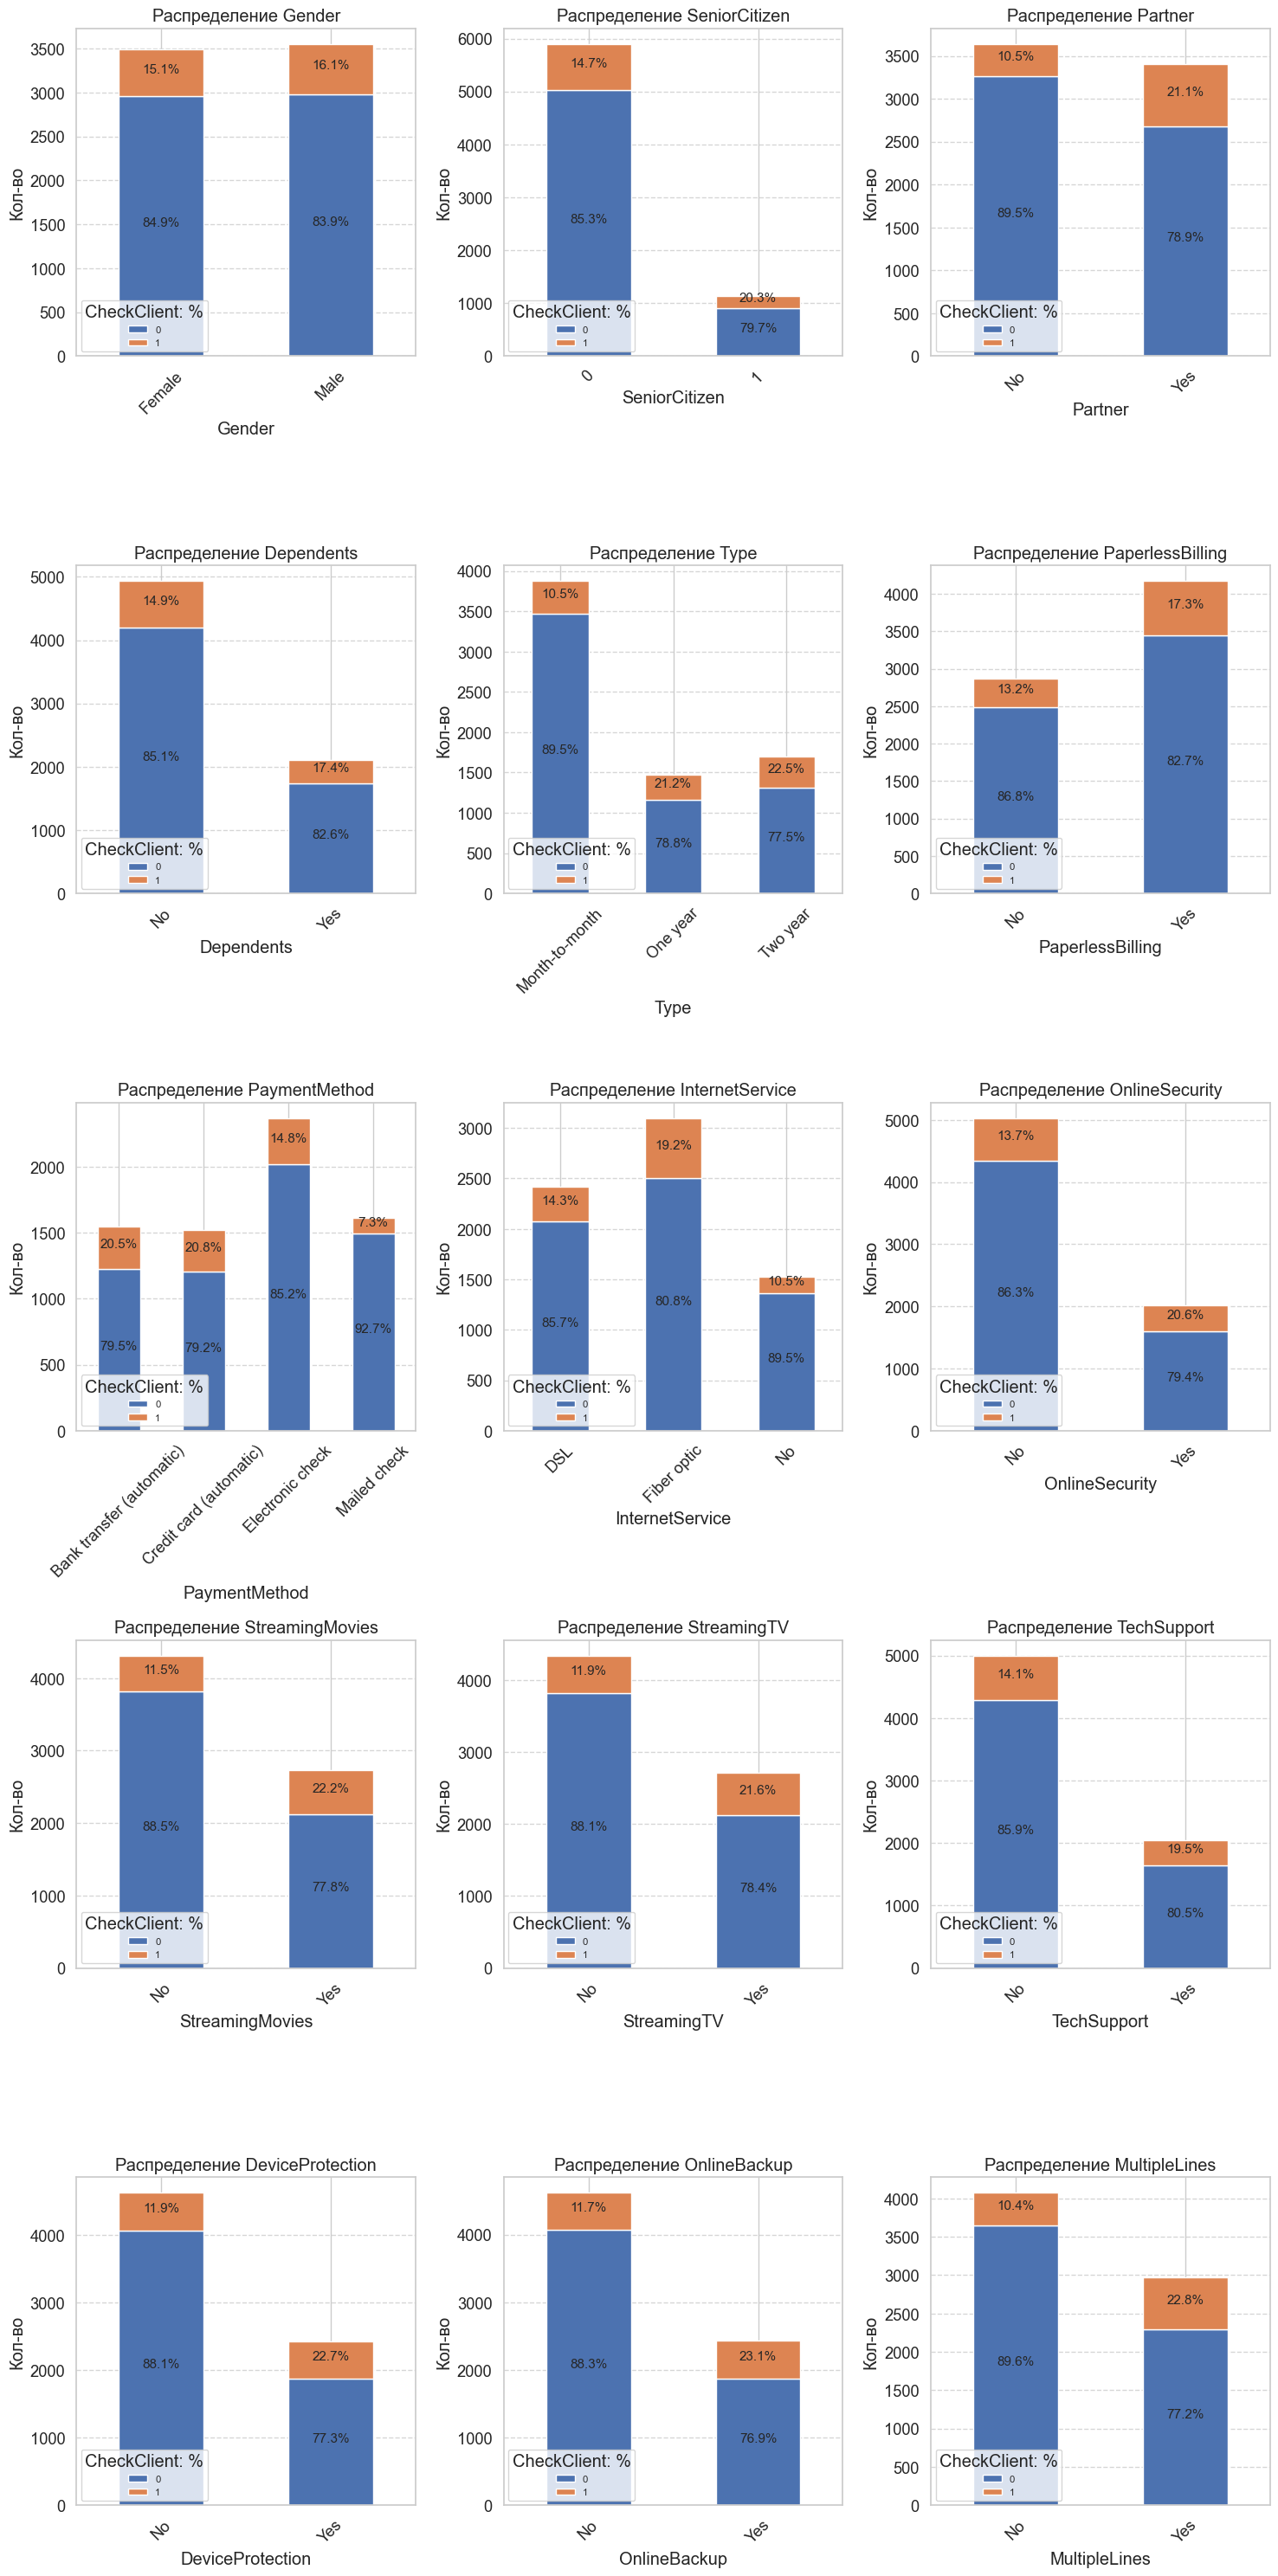

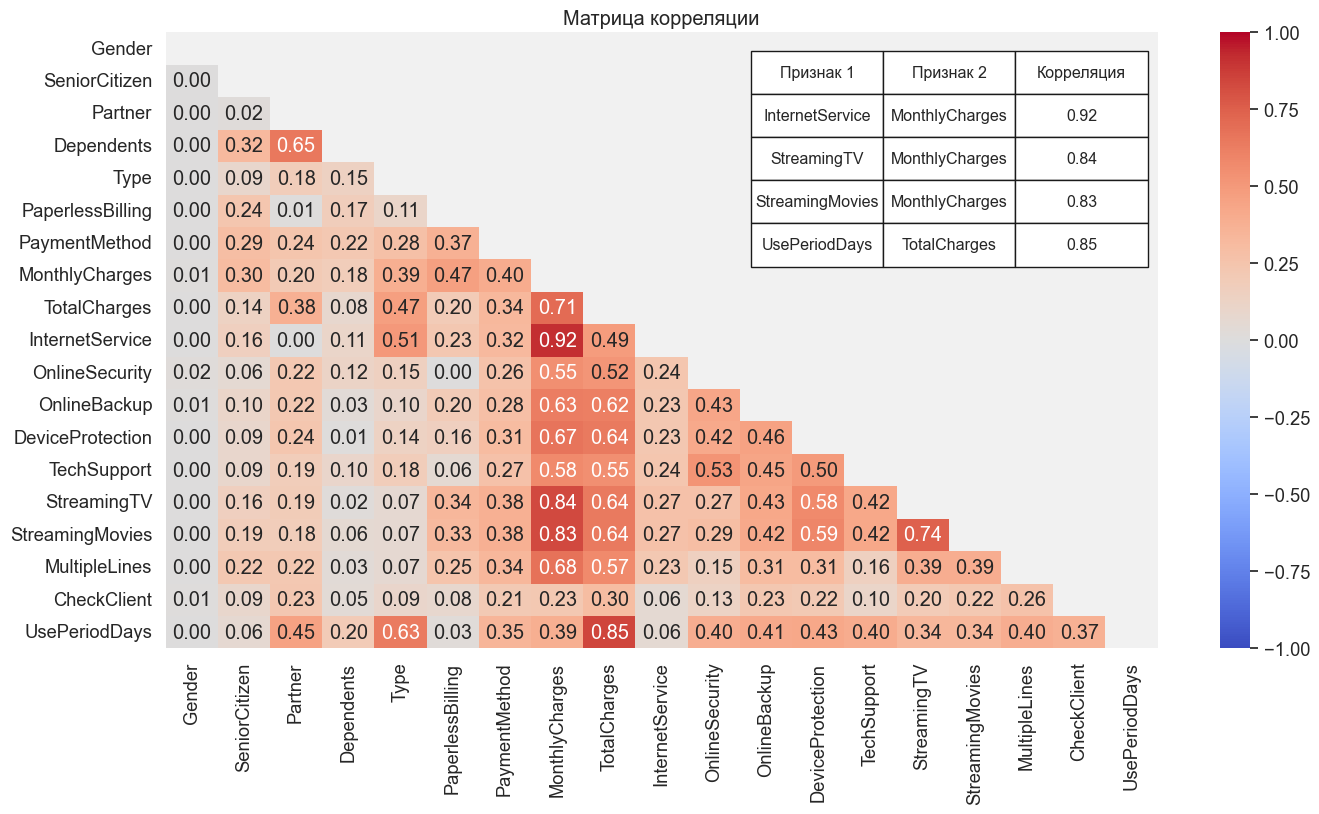

In [75]:
plot_categorical_distribution(total_data, 'CheckClient', ctg_list, graphs_per_row=3)
plot_correlation_matrix(total_data, num_list, matrix_size=(16, 8), threshold=0.75)

---
### 4. По итогам __`подготовки данных к обучению`__ :

Для подготовки данных к обучению, были созданы обучающие и тестовые выборки в пропорции 3 к 1. Также были разработаны два экземпляра функции-трансформера для предобработки данных, подходящие для разных моделей машинного обучения

---
### 5. По итогам __`обучения моделей`__ :

 Было обучено четыре различные модели с использованием методов машинного обучения, включая `LogisticRegression`, `RandomForestClassifier`, `CatBoostClassifier` и `GradientBoostingClassifier`. Обучение проводилось с использованием пайплайнов и метода <u>GridSearchCV</u> для подбора гиперпараметров. Модели были оценены по метрике _ROC AUC_, и наилучший результат показала модель `GradientBoostingClassifier` с оценкой __0.9063__.

| Модель                      | ROC AUC   |
|-----------------------------|-----------|
| LogisticRegression          | 0.7472    |
| RandomForestClassifier      | 0.8244    |
| CatBoostClassifier          | 0.9052    |
| GradientBoostingClassifier  | 0.9063    |

Модель `GradientBoostingClassifier` это мощный ансамблевый метод машинного обучения, который используется для задач классификации. Этот метод построен на идее комбинирования нескольких слабых моделей (обычно деревьев решений) в одну сильную модель, с целью улучшения качества классификации.

Параметры лучшей модели `GradientBoostingClassifier`:
- `model__learning_rate`: __0.2__
- `model__max_depth`: __4__
- `model__n_estimators`: __200__

---
### 6. По итогам __`проверки модели`__ :

На основе тестирования модели на тестовых данных был получен `ROC AUC Score` величиной __0.94__, что свидетельствует о высоком качестве предсказаний и хорошей разделимости классов. Однако стоит обратить внимание на разницу между значениями `ROC AUC` на тренировочных и тестовых данных, что может указывать на переобучение модели. Для предотвращения переобучения в будущем, можно рассмотреть введение параметра _subsample_ для регуляризации модели.

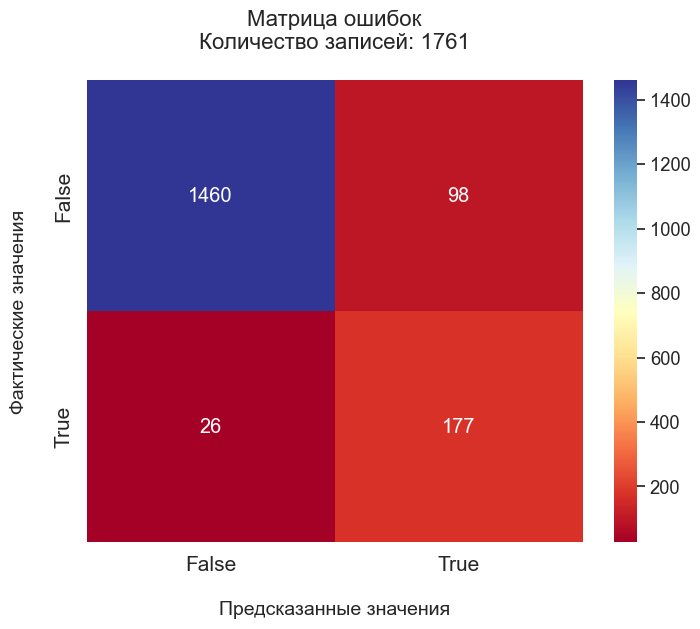

In [76]:
plot_conf_matr(gbc_grid_search,
               features_test,
               target_test)

- Верхний левый квадрант __(1460)__: Это кол-во истинно негативных _(True Negative)_ предсказаний модели. В данном контексте это означает, что модель правильно классифицировала __1460__ случаев, в которых клиент не уйдет.

- Верхний правый квадрант __(98)__: Это количество ложно позитивных _(False Positive)_ предсказаний модели. Модель неправильно классифицировала __98__ случаев как положительные, когда они на самом деле были отрицательными, т.е ошибка в предсказании клиентов, которые уйдут.

- Нижний левый квадрант __(26)__: Это количество ложно негативных _(False Negative)_ предсказаний модели. Модель неправильно классифицировала __26__ случаев как отрицательные, когда они на самом деле были положительными. В данном случае, что пользователи, которые не должны уйти - уйдут.

- Нижний правый квадрант __(177)__: Это количество истинных положительных _(True Positive)_ предсказаний модели. Модель правильно классифицировала __177__ случаев как положительные, и они были действительно положительными, т.е модель хорошо предсказывает пользователей, которые на самом деле не уйдут.

Также, лучшая модель, `GradientBoostingClassifier`, достигла метрики (accuracy) на тестовых данных в размере __0.93__, что также подтверждает высокое качество модели.

Анализ важности признаков выявил, что наибольшее влияние на результат исследования оказывают следующие признаки:

- `Длительность пользования услугами(num__UsePeriodDays)` (важность: __0.579__) 
- `Сумма ежемесячных трат на услуги (num__MonthlyCharges)` (важность: __0.164__)
- `Тип договора: ежемесячный, годовой и т.д (cat__Type)` (важность: __0.099__)
- `Наличие супруга/супруги (cat__Partner)` (важность: __0.020__)

С другой стороны, признаки, такие как Пол клиента `cat__Gender`, а также услуги `cat__OnlineSecurity` и `cat__TechSupport`, оказывают меньшее влияние на предсказания модели.

Эти результаты позволяют сделать выводы о том, какие факторы сильнее всего влияют на решение клиента об уходе или оставании, что может быть полезно для дальнейшей разработки стратегии удержания клиентов. <u>Таблица важности признаков приведена ниже.</u>

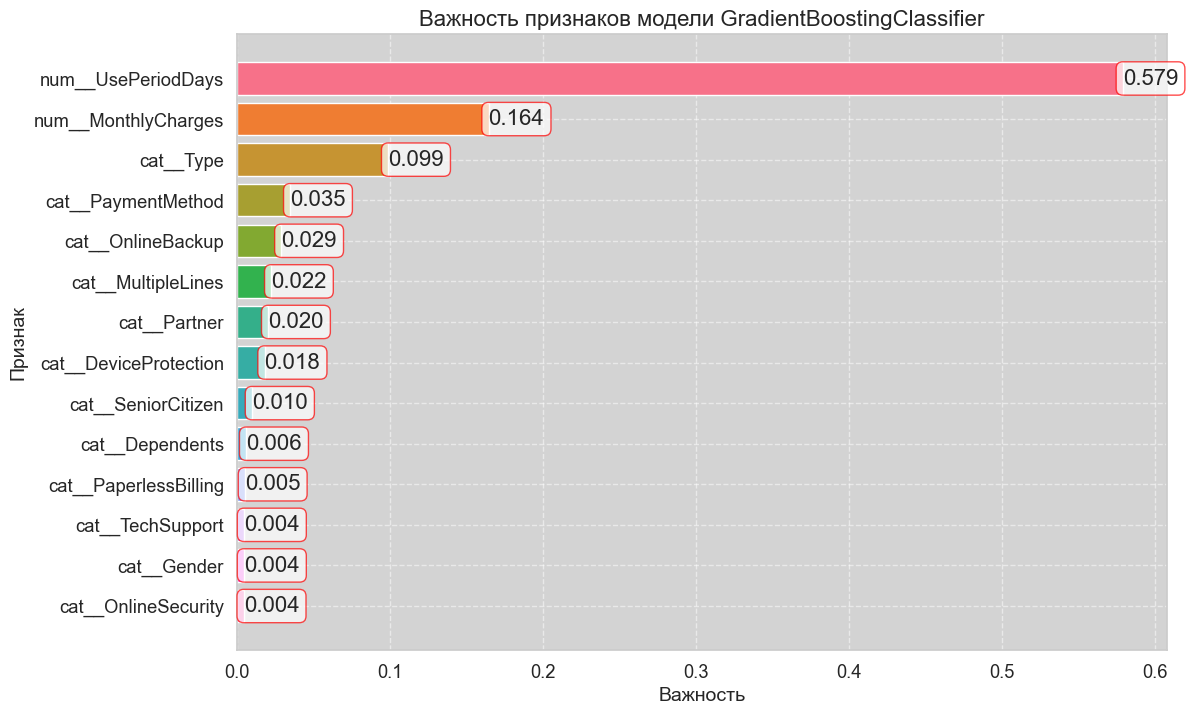

In [77]:
plot_feature_importance(importances_df,
                        title="Важность признаков модели GradientBoostingClassifier",
                        xlabel="Важность",
                        ylabel="Признак")

---
### Затруднения.

1. Данные изначально не содержали явного целевого признака, указывающего, ушел ли клиент или остался. Для создания целевого признака было решено использовать столбец `EndDate`. Если значение в этом столбце было равно `2020-02-01` (дате выгрузки данных), то клиент считался оставшимся, в противном случае он считался ушедшим. Изначально в столбце `EndDate` могли быть как даты ухода клиентов, так и значение `No`, что указывало на то, что клиент ещё не ушел. Для унификации данных было принято решение заменить значения `No` на дату выгрузки данных `2020-02-01`, чтобы определить статус клиента.
---
2. Также, в нашей текущей задаче, связанной с прогнозированием ухода клиентов, наблюдается проблема дисбаланса классов. Это означает, что кол-во клиентов, которые остаются, значительно больше, чем кол-во клиентов, которые уходят. Этот дисбаланс может повлиять на способность модели правильно классифицировать клиентов, которые ушли. Для решения этой проблемы были применены методы работы с несбалансированными данными, а именно, метрика `ROC AUC`, которая не чувствительна к дисбалансу.
---

### Рекомендации.

1. Улучшение сбора данных: по возможности, Заказчику рекомендуется подготовить более обширный набор данных с дополнительными признаками, чтобы модель могла обучиться на большем объеме информации. Это может улучшить обобщающую способность модели.

---
2. Заказчику при дальнейшей разработке модели стоит обратить внимание на разницу между значениями `ROC AUC` на тренировочных и тестовых данных, что может указывать на переобучение модели. Для предотвращения переобучения в будущем, можно рассмотреть введение параметра _`subsample`_ и др. для регуляризации модели.
---
---
---